In [1]:
import pennylane as qml
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
n = 4 # n qubits
m = 2 * n # double qubits for preparing target state
n_layers = n ** 2 # number of layers in variational circuit
dev = qml.device('default.qubit', wires=m)

In [3]:
def variational_circuit(n_layers, weights, wires, **kwargs):
    '''
        Template for a variational circuit.
    '''
    pos = 0
    for i in range(len(wires)):
        qml.RX(weights[pos], wires=wires[i])
        qml.RY(weights[pos+1], wires=wires[i])
        qml.RZ(weights[pos+2], wires=wires[i])
        pos += 3

    for layer in range(n_layers):
        for i in range(len(wires)-1):
            qml.CNOT(wires=[wires[i], wires[i+1]])
        qml.CNOT(wires=[wires[len(wires)-1], wires[0]])
        
        for i in range(len(wires)):
            qml.RX(weights[pos], wires=wires[i])
            qml.RY(weights[pos+1], wires=wires[i])
            qml.RZ(weights[pos+2], wires=wires[i])
            pos += 3

In [4]:
def get_target(n_layers, params, **kwargs):
    '''
        Prepare target state at the first n qubits.
    '''
    variational_circuit(n_layers, params, np.arange(m))

In [5]:
def variational_qpca(n_layers, variational_params, **kwargs):
    '''
        Perform variational quantum PCA.
    '''
    variational_circuit(n_layers, variational_params, np.arange(n))

In [6]:
@qml.qnode(dev, interface="tf")
def measurement(n_layers, target_params, variational_params, **kwargs):
    '''
        Measure sigma_z for computing PCA loss.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    z = []
    for i in range(n):
        z.append(qml.expval(qml.PauliZ(i)))
    return z

def loss_qpca(n_layers, target_params, variational_params, **kwargs):
    '''
        Compute loss for variational quantum PCA, i.e. $Tr(U \rho U^dagger P)$.
    '''
    z = measurement(n_layers, target_params, variational_params)
    return 1 / 2 ** n / (2 ** n - 1) * tf.math.reduce_sum((z + 1) * (2 ** tf.range(n, dtype=tf.double)))

In [7]:
# initialize parameters
np.random.seed(0)
n_target_params = (m + 1) * 3 * n_layers
n_var_params = (n + 1) * 3 * n_layers

target_params = np.array([0] * n_target_params) + np.random.normal(scale=np.pi, size=(n_target_params,))

eps = 1e-2
init_var_params = np.array([0] * n_var_params) + np.random.normal(scale=eps, size=(n_var_params,))
var_params = tf.Variable(init_var_params)

# SGD faces barren plateau, Adam is better
# lr = 6 for SGD, 0.1 for Adam
opt = tf.keras.optimizers.Adam(0.1)

In [8]:
# examine the target state
@qml.qnode(dev, interface="tf")
def get_target_state(n_layers, target_params, **kwargs):
    '''
        Get density matrix of the target state.
    '''
    get_target(n_layers, target_params)
    return qml.density_matrix(list(range(n)))

# sigular value decomposition
target_state = get_target_state(n_layers, target_params).numpy()
U, S, V = np.linalg.svd(target_state)
print('eigenvalues: ', S)

# calculate theoretical minimum of loss
loss_minimum = np.sum(S * np.arange(len(S))) / 2 ** n / (2 ** n - 1) * 2
print('loss minimum: ', loss_minimum)

eigenvalues:  [2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
loss minimum:  0.025312073598619776


In [9]:
# train variational quantum PCA
n_step = 200

cost = lambda: loss_qpca(n_layers, target_params, var_params)

cost_list = []
for step in range(n_step):
    opt.minimize(cost, var_params)
    cost_val = cost().numpy()
    cost_list.append(cost_val)
    if step % 5 == 0:
        print("Step {}: cost = {}, relative excess = {}".format(step, cost_val, (cost_val - loss_minimum) / loss_minimum))

Step 0: cost = 0.05899180581419453, relative excess = 1.3305797363599343
Step 5: cost = 0.040022414521626776, relative excess = 0.581159060939564
Step 10: cost = 0.0350436524705432, relative excess = 0.38446391339720476
Step 15: cost = 0.0321092871103502, relative excess = 0.26853641544804396
Step 20: cost = 0.03044950759548679, relative excess = 0.2029637744553314
Step 25: cost = 0.029321562786115807, relative excess = 0.15840224120218507
Step 30: cost = 0.028373394142066015, relative excess = 0.12094309585182177
Step 35: cost = 0.027780552740028847, relative excess = 0.09752180641350826
Step 40: cost = 0.027313770479578524, relative excess = 0.07908071510458538
Step 45: cost = 0.02697651365092221, relative excess = 0.0657567640919467
Step 50: cost = 0.026752413964756045, relative excess = 0.056903294015975374
Step 55: cost = 0.026588963637531795, relative excess = 0.05044588835983968
Step 60: cost = 0.026454834873467566, relative excess = 0.04514688495967799
Step 65: cost = 0.0263378

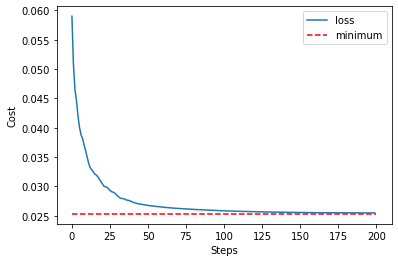

In [10]:
# plot loss
plt.plot(cost_list, label='loss')
plt.hlines(loss_minimum, 0, n_step, colors='r', linestyles='--', label='minimum')
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.legend()
plt.show()

In [11]:
@qml.qnode(dev, interface="tf")
def get_pca_state(n_layers, target_params, variational_params, **kwargs):
    '''
        Get density matrix of the PCA result.
    '''
    get_target(n_layers, target_params)
    variational_qpca(n_layers, variational_params)
    return qml.density_matrix(list(range(n)))

eigenvalues:  [2.17700316e-01 1.81401684e-01 1.38392838e-01 1.19328333e-01
 8.64941820e-02 6.76431777e-02 4.87401697e-02 4.05142797e-02
 2.96022492e-02 2.53171071e-02 1.91009725e-02 1.15756290e-02
 8.28834778e-03 4.12904668e-03 1.68351381e-03 8.81536456e-05]
pca results:  [0.21750726 0.1813649  0.13806766 0.11945471 0.08659847 0.0660452
 0.04949612 0.0396361  0.02941015 0.02565163 0.01932473 0.01187646
 0.00780104 0.00419598 0.00214315 0.00142645]
eigenvalue mse:  4.1256464260853657e-07


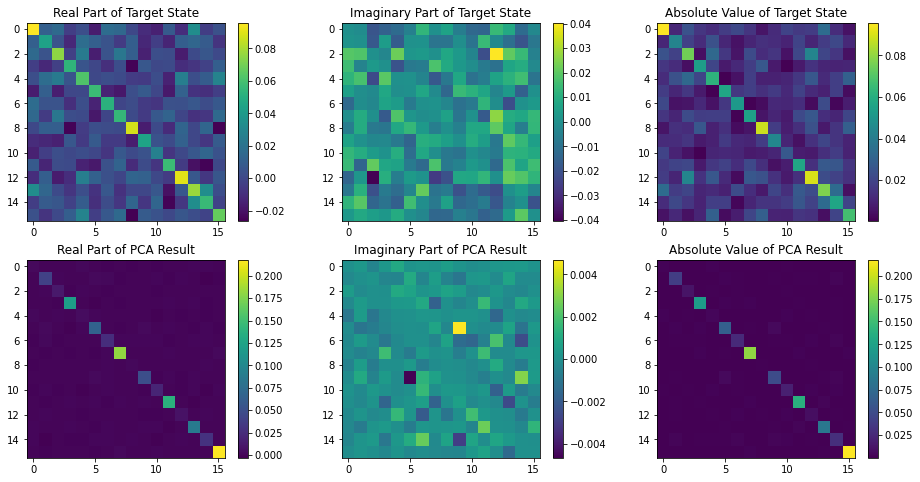

In [12]:
print('eigenvalues: ', S)

pca_state = get_pca_state(n_layers, target_params, var_params).numpy()
pca_eigen = -np.sort(-np.abs(np.diag(pca_state)))

print('pca results: ', pca_eigen)
print('eigenvalue mse: ', np.mean((pca_eigen - S) ** 2))

fig, ax = plt.subplots(2, 3, figsize=(16, 8))

im_target_real = ax[0][0].imshow(np.real(target_state))
ax[0][0].set_title('Real Part of Target State')
plt.colorbar(im_target_real, ax=ax[0][0])
im_target_imag = ax[0][1].imshow(np.imag(target_state))
ax[0][1].set_title('Imaginary Part of Target State')
plt.colorbar(im_target_imag, ax=ax[0][1])
im_target_abs = ax[0][2].imshow(np.abs(target_state))
ax[0][2].set_title('Absolute Value of Target State')
plt.colorbar(im_target_abs, ax=ax[0][2])

im_pca_real = ax[1][0].imshow(np.real(pca_state))
ax[1][0].set_title('Real Part of PCA Result')
plt.colorbar(im_pca_real, ax=ax[1][0])
im_pca_imag = ax[1][1].imshow(np.imag(pca_state))
ax[1][1].set_title('Imaginary Part of PCA Result')
plt.colorbar(im_pca_imag, ax=ax[1][1])
im_pca_abs = ax[1][2].imshow(np.abs(pca_state))
ax[1][2].set_title('Absolute Value of PCA Result')
plt.colorbar(im_pca_abs, ax=ax[1][2])

plt.show()